# Pipeline to Detect Lanes
---

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
import utility

%matplotlib inline
%load_ext autoreload

/Users/karl/Tools/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Prototyping Data
### Write a second (30 frames) to test image directory from a file

In [2]:
Debugging_Images = False
if Debugging_Images:

    imagenumber = 0
    def write_testims(img):
        global imagenumber
        newim = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imname = 'examples/example-images/test_images_{:03}.jpg'.format(imagenumber)
        cv2.imwrite(imname, newim)
        imagenumber += 1
        return img

    from moviepy.editor import VideoFileClip
    video_output1 = 'test_video_output.mp4'
    video_input1 = VideoFileClip('test_video.mp4').subclip(0,1)
    processed_video = video_input1.fl_image(write_testims)
    %time processed_video.write_videofile(video_output1, audio=False)


## Training Files

In [3]:
# Read in cars and notcars
images = glob.glob('dataset/*/*/*.png')
cars = []
notcars = []
for image in images:
    if image[8]=='n':
        notcars.append(image)
    else:
        cars.append(image)

## Data Exploration

The left side are cars and the right side are not cars. Simply take a random sampling of images in the dataset

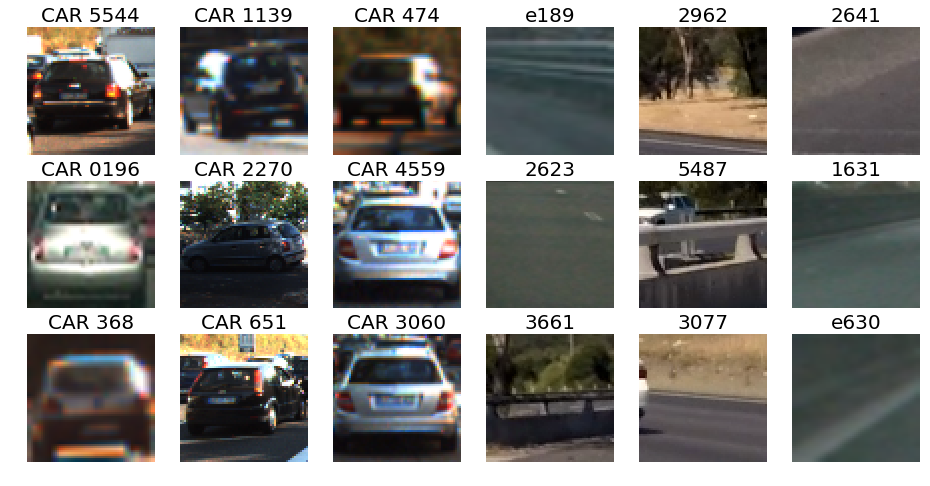

In [4]:
from utility import show_images

vis_images = []
vis_labels = []
for i in range(3):
    vis_images+= list(np.random.choice(cars,size=3))
    vis_labels+= [vis_image.split('/')[-1].split('.')[0][-4:] for vis_image in vis_images[-3:]]
    vis_labels[-3:] = ['CAR '+vis_image for vis_image in vis_labels[-3:]]
    vis_images+= list(np.random.choice(notcars,size=3))
    vis_labels+= [vis_image.split('/')[-1].split('.')[0][-4:] for vis_image in vis_images[-3:]]

show_images(vis_images , titles=vis_labels, rows=3, figsize=(16,8) )

## Define the window function from perspective

Using the perspective transformation, I'm able to bounds on images at different $y$-coordinates. I will search these windows with some $\pm \epsilon$. That is to say:

$$
y = \frac{ \left( y_{bottom} - y_{top}\right) }{ \left(win_{max} - win_{min}\right) }(win-win_{min}) + y_{top}
$$

or

$$
win = \frac{ \left( win_{max} - win_{min} \right) }{ \left( y_{bottom} - y_{top}\right) } (y-y_{top}) + win_{min}
$$

Here, $y_{off}$ is the offset of $y$ between 0 and 1, if we were to stay within bottom and top.

The original parameters used in the original images can be used an example.
```
w_min = 32; w_max = 175  - Window minimum and maximum sizes
y_bottom = [510, 685]    - The y-bounds (top and bottom) of the window closest to the vehicle
y_top = [500, 532]       - The y-bounds (top and bottom) of the window furthest from the vehicle
```

In [12]:
# The largest and smallest window size is dependent on y
w_min = 32; w_max = 250
y_bottom = [425, 775]
y_top = [415, 452]

def y_window( winsize, w_max, w_min, y_bottom, y_top ):
    winslope = (w_max - w_min) / (np.array(y_bottom) - np.array(y_top))
    return list(np.round( (winsize - w_min)/winslope + np.array(y_top) ).astype(np.int))

# Let's take a look at the midpoint
w_mid = round( (w_max - w_min)/2 + w_min)
y_mid = y_window( w_mid, w_max, w_min, y_bottom, y_top )

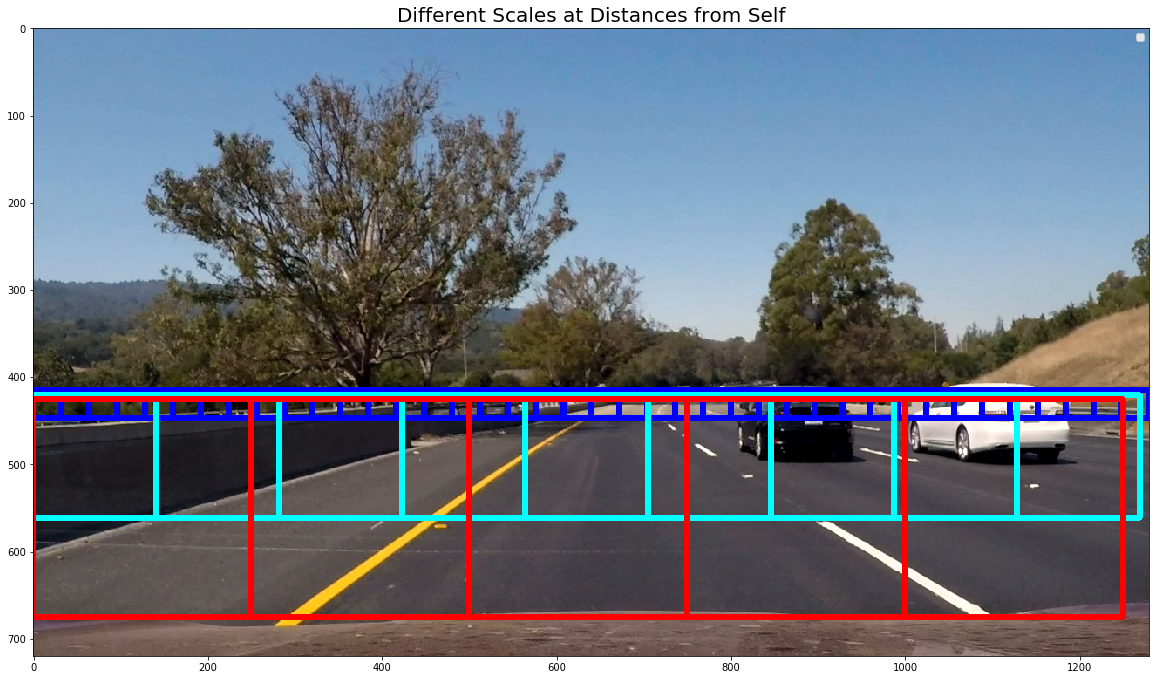

In [13]:
# image = 'test_images/bbox-example-image.jpg'
image = 'test_images/example-images/test_images_000.jpg'
windows_large = slide_window(image, x_start_stop=[None, None], y_start_stop=y_bottom,
                             xy_window=(w_max,w_max), xy_overlap=(0, 0))
windows_medium = slide_window(image, x_start_stop=[None, None], y_start_stop=y_mid,
                             xy_window=(w_mid,w_mid), xy_overlap=(0, 0))
windows_small = slide_window(image, x_start_stop=[None, None], y_start_stop=y_top,
                             xy_window=(w_min,w_min), xy_overlap=(0, 0))

# Draw small medium and large windows on the image
window_img = draw_boxes(image, windows_small, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, windows_medium, color=(0, 255, 255), thick=6)
window_img = draw_boxes(window_img, windows_large, color=(255, 0, 0), thick=6)

plt.figure(figsize=(20,20))
plt.imshow(window_img)
plt.legend(['Small','Medium','Large'])
plt.title('Different Scales at Distances from Self', fontsize=20)

## Define a good set of windows

In [7]:
window_set = []
y_step = 16
# Linear range from minimum window size to maximum
for win in range(w_min, w_max, y_step):
    y_ss = y_window( win, w_max, w_min, y_bottom, y_top )
    window_set += slide_window(image, x_start_stop=[None, None], y_start_stop=y_ss,
                               xy_window=(win,win), xy_overlap=(0.25, 0.25))

    
print("Number of windows to check: {}".format(len(window_set)))

Number of windows to check: 237


## Train a Classifier with Support Vector Machines
---

Parameter settings

In [8]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = -1
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

Extract features and train classifiers

In [9]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

/Users/karl/Tools/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
8.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9727


In [18]:
# Save the model
import pickle
svcparamfile = open("SVC_params.pkl",'wb')
pickle.dump(svc, svcparamfile)
svcparamfile.close()

/Users/karl/Tools/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


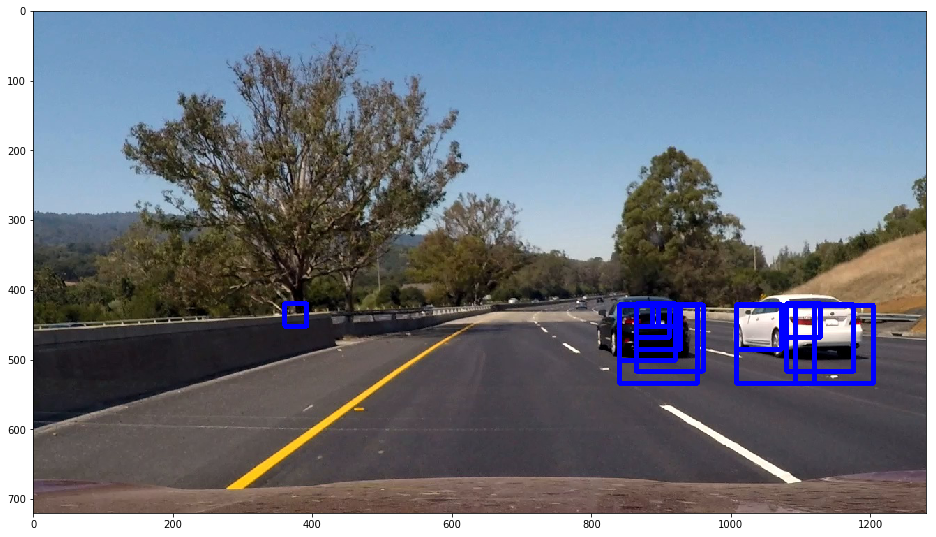

In [10]:
# image = mpimg.imread('test_images/bbox-example-image.jpg')
image = mpimg.imread('test_images/example-images/test_images_000.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

hot_windows = search_windows(image, window_set, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.figure(figsize=(16,16))
plt.imshow(window_img)

In [11]:
ystart = 400
ystop = 656
scale = 1.5

%autoreload
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

/Users/karl/Tools/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: operands could not be broadcast together with shapes (1,6108) (2580,) (1,6108) 